# Gauss-Seidel method
## Introduction
The general expression for the apparent power at bus $i$ is:
$$ \underline{S}_i=\underline{V}_i\cdot \underline{I}_i^*=\underline{V}_i\cdot \sum_{j}{\underline{Y}_{ij}\cdot \underline{V}_j}$$
Taking its conjugate:
$$\Rightarrow \frac{\underline{S}_i^*}{\underline{V}_i^*}=\sum_{j}{\underline{Y}_{ij}\cdot \underline{V}_j}=\underline{Y}_{ii}\cdot \underline{V}_i+\sum_{j\ne i}{\underline{Y}_{ij}\cdot \underline{V}_j}$$
$Y_{ii}$ is the bus own admittance. Solving for $\underline{V}_i$ gives:
$$\underline{V}_i=\frac{1}{\underline{Y}_{ii}}\cdot \left\{ \frac{P_i-j\cdot Q_i}{\underline{V}_i^*}-\sum_{j\ne i}{\underline{Y}_{ij}\cdot \underline{V}_j}\right\} $$
The above equation has the unknown term $\underline{V}_i$ on both sides and needs to be implicitely solved.
## Solution for PQ buses
At PQ buses, $P_i$ and $Q_i$ are known (specified). The equation for calculating the voltage $\underline{V}_i^{(k+1)}$ during the new iteration $k+1$ from its value $\underline{V}_i^{(k)}$ at the previous iteration is:
$$\underline{V}_i^{(k+1)}=\frac{1}{\underline{Y}_{ii}}\cdot \left\{ \frac{P_i-j\cdot Q_i}{\left( \underline{V}_i^{(k)}\right) ^*}-\sum_{j=1}^{i-1}{\underline{Y}_{ij}\cdot \underline{V}_j^{(k+1)}}-\sum_{j=i+1}^N{\underline{Y}_{ij}\cdot \underline{V}_j^{(k)}}\right\} $$
## Solution for PV buses
At PV buses, $P_i$ and $V_i$ are known (specified). For each iteration we calculate the reactive power of a PV bus as:
$$Q_i=-Im\left\{\underline{V}_i^* \sum_{j=1}^N{\underline{Y}_{ij}\cdot \underline{V}_j}\right\}$$
For iteration $k+1$ the voltages for all buses $j=1 \ldots i-1$ have been updated, hence:
$$Q_i^{(k+1)}=-Im\left\{\left(\underline{V}_i^{(k)}\right)^*\cdot\left[ \sum_{j=1}^{i-1}{\underline{Y}_{ij}\cdot \underline{V}_j^{(k+1)}}+\sum_{j=i}^N{\underline{Y}_{ij}\cdot \underline{V}_j^{(k)}}\right]\right\}$$

The steps for each PV bus are:
1. compute $Q_i^{(k+1)}$ using the equation above
1. If the calculated reactive power exceeds the limits specified for the bus, use the upper/lower limit instead. For the current iteration, the bus is treated as PQ bus (ignore the last step)
   1. if $Q_i^{(k+1)}<Q_{i,\min}$ then $Q_i^{(k+1)}=Q_{i,\min}$
   1. if $Q_i^{(k+1)}>Q_{i,\max}$ then $Q_i^{(k+1)}=Q_{i,\max}$
1. Calculate $\underline{V}_i^{(k+1)}$ using equation the basic equation for the Gauss-Seidel algorithm (see PQ bus above) with $Q_i=Q_i^{(k+1)}$
1. If the calculated reactive power is within limits, the bus is treated as PV bus with its voltage magnitude specified to $\hat{V}_i$. In this case only keep the phase angle $\theta_i^{(k+1)}$ of the voltage calculated in the step above. The updated value for the voltage is therefore:
$$\underline{V}_i^{(k+1)}=\hat{V}_i\angle \; \theta_i^{(k+1)}$$
## Convergence
At the end of each iteration, the change in voltage between iterations is evaluated for each bus. If it is below a specified threshold $\varepsilon$ (typically $10^{-5}$ to $10^{-4}$) for all buses, the algorithm ends
$$\Delta \underline{V}_i^{(k+1)}=\left| \underline{V}_i^{(k+1)}-\underline{V}_i^{(k+1)} \right|\le \varepsilon \ \ \forall i=1\ldots N$$

---
# Example

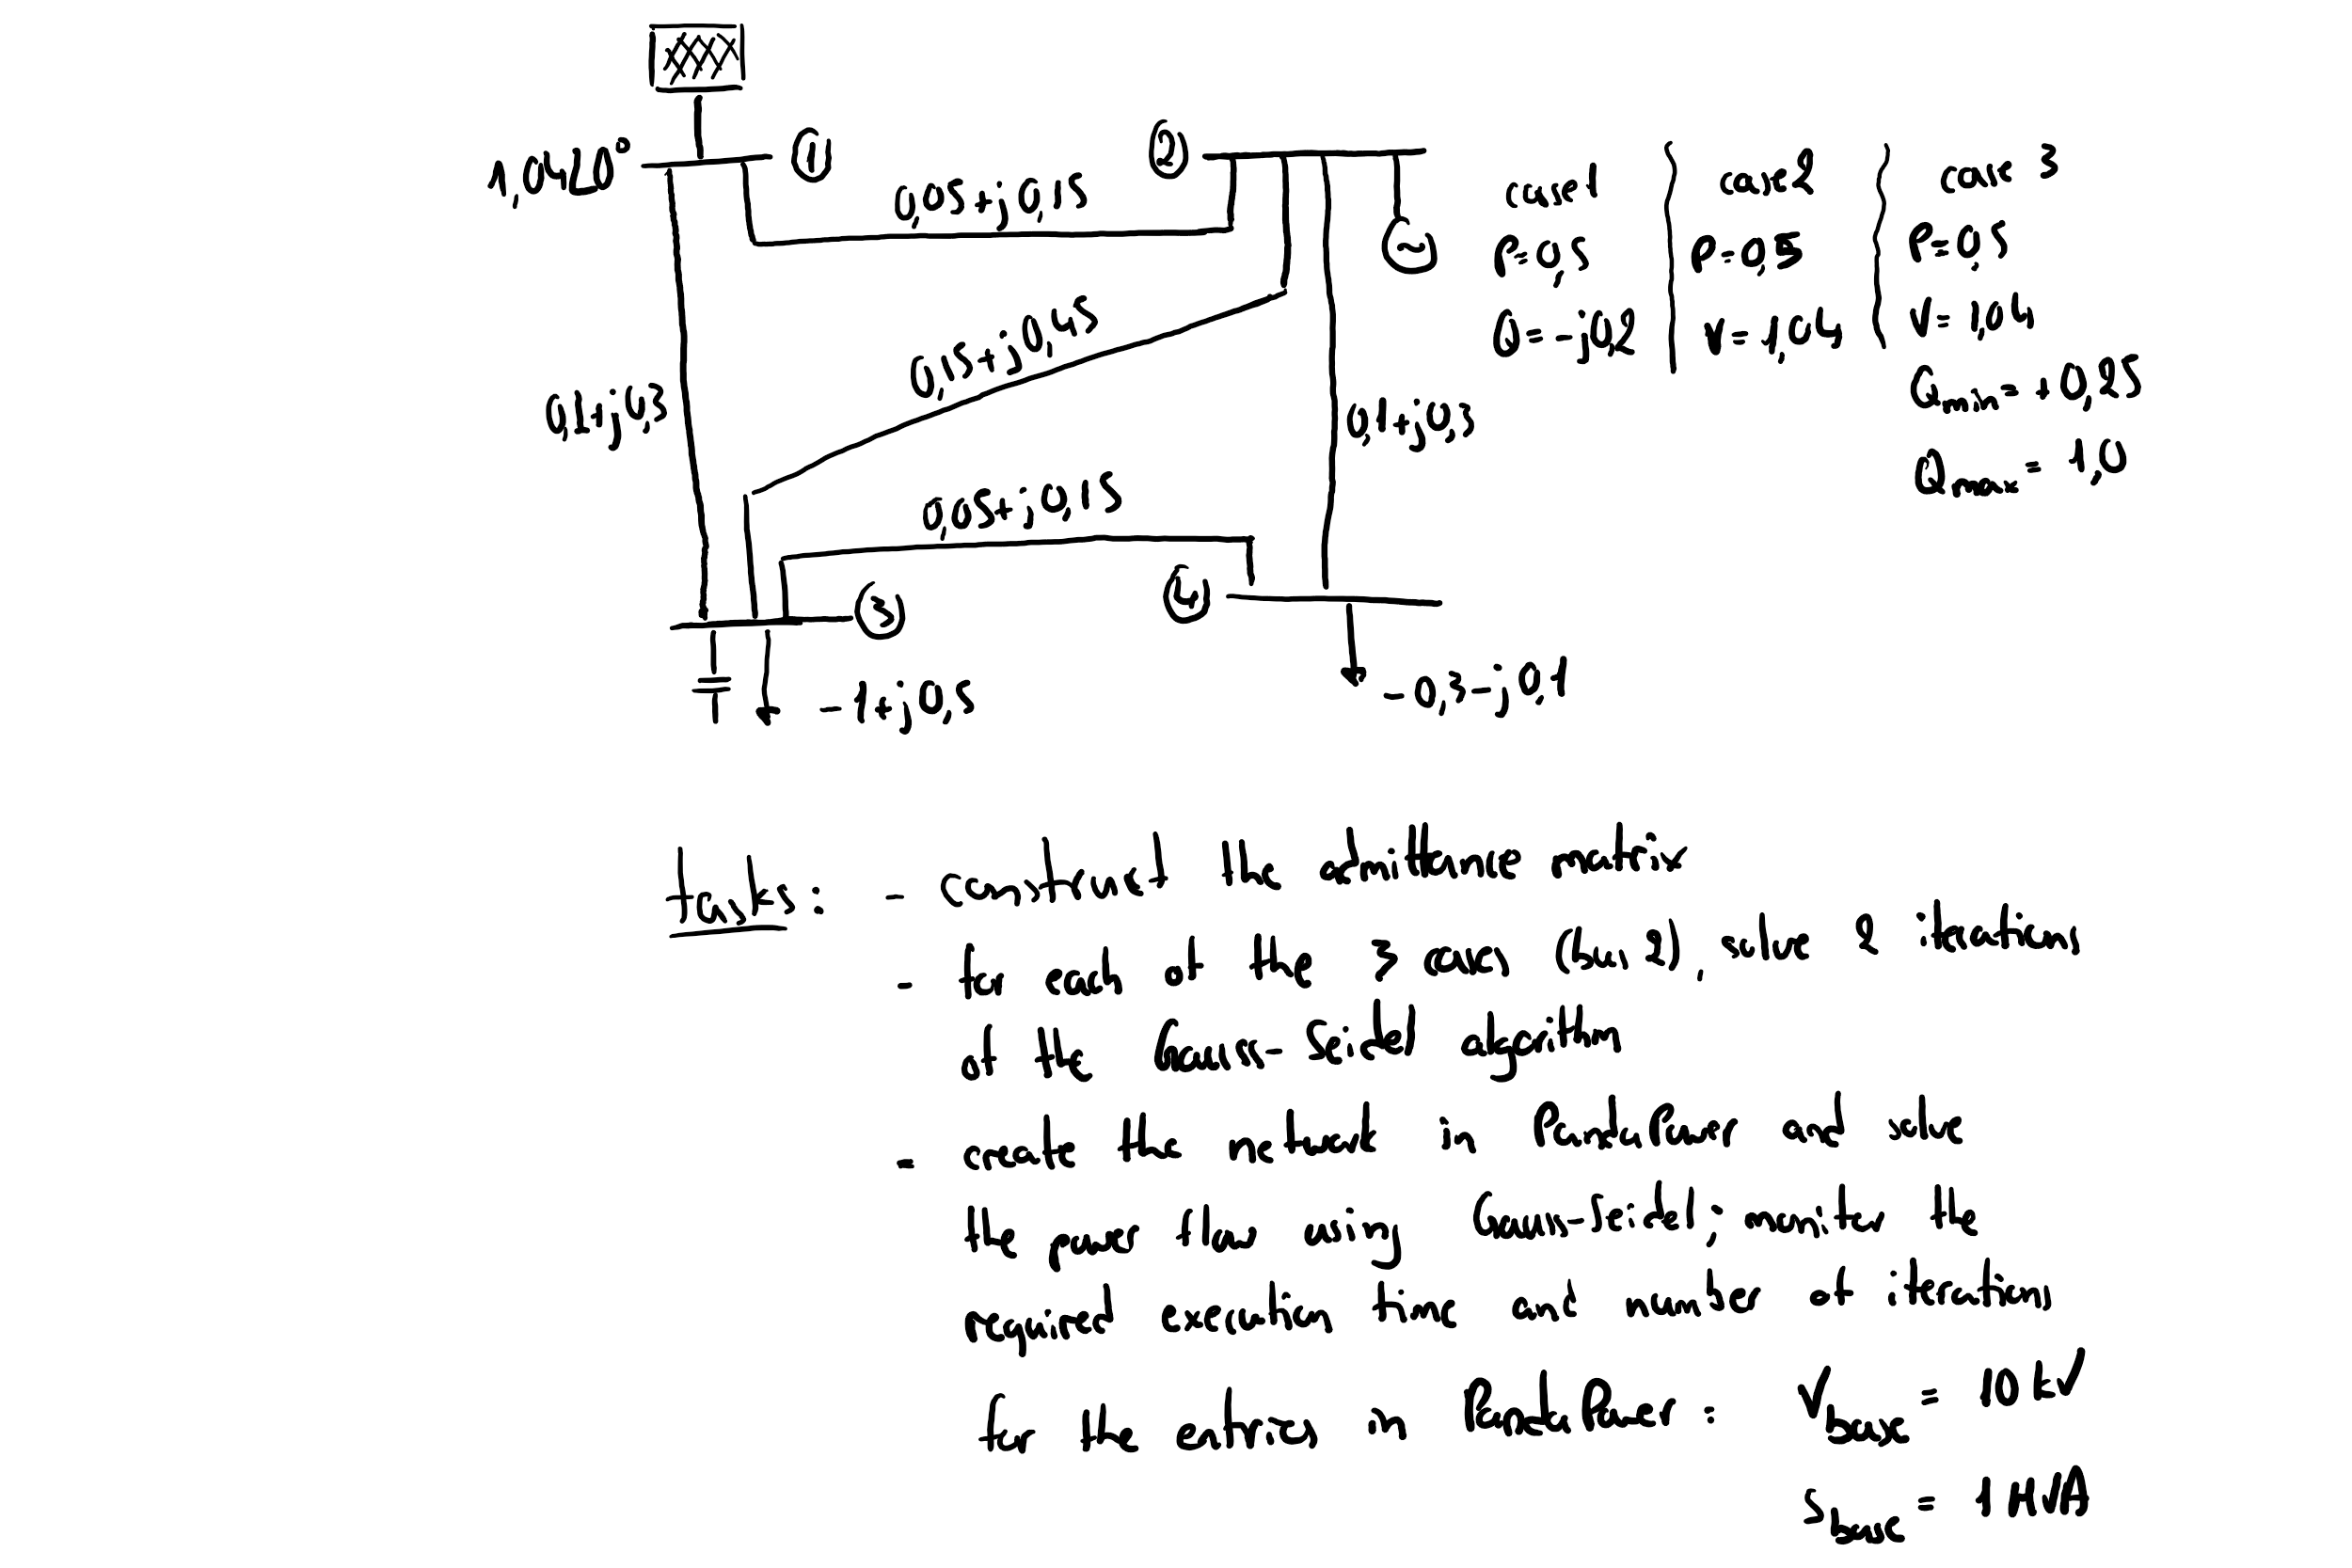

The impedance matrix for the grid is shown below. Shunt elements are set to open-circuit (infinite impedance), same applies for branches between buses without any (direct) connecting line.

In [496]:
import numpy as np
from IPython.display import display, Latex
Z = np.array([[np.inf,0.05+0.15j,0.1+0.3j,np.inf],
               [0.05+0.15j,np.inf,0.15+0.45j,0.1+0.3j],
               [0.1+0.3j,0.15+0.45j,np.inf,0.05+0.15j],
               [np.inf,0.1+0.3j,0.05+0.15j,np.inf]],
              dtype = complex)
print(Z)

[[ inf+0.j   0.05+0.15j 0.1 +0.3j   inf+0.j  ]
 [0.05+0.15j  inf+0.j   0.15+0.45j 0.1 +0.3j ]
 [0.1 +0.3j  0.15+0.45j  inf+0.j   0.05+0.15j]
 [ inf+0.j   0.1 +0.3j  0.05+0.15j  inf+0.j  ]]


The bus admittance matrix is formed directly as follows: First, we calculate the admittance of each line: $\underline{Y}_{ij}=\frac{1}{\underline{Z}_{ij}}$

In [497]:
Y=Z.copy()
with np.nditer(Y, op_flags=['readwrite']) as it:
   for x in it:
       x[...] = -1/x

In a second step, we calculate the shunt addmitance by summing over each row and multiplying with -1.

In [498]:
for i in range(4):
    Y[i][i]=-Y.sum(axis=1)[i]
print(Y)

[[ 3.         -9.j -2.         +6.j -1.         +3.j -0.         +0.j]
 [-2.         +6.j  3.66666667-11.j -0.66666667 +2.j -1.         +3.j]
 [-1.         +3.j -0.66666667 +2.j  3.66666667-11.j -2.         +6.j]
 [-0.         +0.j -1.         +3.j -2.         +6.j  3.         -9.j]]


---
## Case 1
All buses except bus 1 are PQ buses

In [499]:
P=np.array([0,0.5,-1,-0.3])
Q=np.array([0,-0.2,0.5,-0.1])

The formulas for updating the voltages are given below:
$$\underline{V}_1^{(k+1)}=\underline{V}_1^{(k)}=1.04\angle 0°$$
$$\underline{V}_2^{(k+1)}=\frac{1}{\underline{Y}_{22}}\cdot \left\{ \frac{P_2-j\cdot Q_2}{\left( \underline{V}_2^{(k)}\right) ^*}-\underline{Y}_{12}\cdot \underline{V}_1^{(k+1)}-\underline{Y}_{23}\cdot \underline{V}_3^{(k)}-\underline{Y}_{24}\cdot \underline{V}_4^{(k)}\right\} $$
$$\underline{V}_3^{(k+1)}=\frac{1}{\underline{Y}_{33}}\cdot \left\{ \frac{P_3-j\cdot Q_3}{\left( \underline{V}_3^{(k)}\right) ^*}-\underline{Y}_{13}\cdot \underline{V}_1^{(k+1)}-\underline{Y}_{23}\cdot \underline{V}_2^{(k+1)}-\underline{Y}_{34}\cdot \underline{V}_4^{(k)}\right\} $$
$$\underline{V}_4^{(k+1)}=\frac{1}{\underline{Y}_{44}}\cdot \left\{ \frac{P_4-j\cdot Q_4}{\left( \underline{V}_4^{(k)}\right) ^*}-\underline{Y}_{24}\cdot \underline{V}_2^{(k+1)}-\underline{Y}_{34}\cdot \underline{V}_3^{(k+1)}\right\} $$

### Iteration 0 - Flat start
Voltage at all buses except for the slack bus is set to $1\angle 0°$. Voltage at the slack bus remains constant throughout all iterations $\underline{V}_1=1.04\angle 0°$.

In [500]:
V = np.array([[1.04],[1],[1],[1]],dtype = complex)
for i in range(4):
    display(Latex(f'$$\\underline{{V}}_{i+1}^{{(0)}}={round(abs(V[i][0]),4)}\u2220 {round(np.angle(V[i][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Iteration 1

In [501]:
display(Latex(f'$$\\underline{{V}}_2^{{(1)}}=\\frac{{1}}{{Y_{{22}}}}\\cdot \\left(\\frac{{{round(P[1],2)}-j\cdot {round(Q[1],2)}}}{{\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[1][0]=1/Y[1][1]*(complex(P[1],-Q[1])/V[1][0].conjugate()-Y[0][1]*V[0][0]-Y[1][2]*V[2][0]-Y[1][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_2^{{(1)}}={round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [502]:
display(Latex(f'$$\\underline{{V}}_3^{{(1)}}=\\frac{{1}}{{Y_{{33}}}}\\cdot \\left(\\frac{{{round(P[2],2)}-j\cdot {round(Q[2],2)}}}{{\\left({round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{13}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[2][0]=1/Y[2][2]*(complex(P[2],-Q[2])/V[2][0].conjugate()-Y[0][2]*V[0][0]-Y[1][2]*V[1][0]-Y[2][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_3^{{(1)}}={round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [503]:
display(Latex(f'$$\\underline{{V}}_4^{{(1)}}=\\frac{{1}}{{Y_{{44}}}}\\cdot \\left(\\frac{{{round(P[3],2)}-j\cdot {round(Q[3],2)}}}{{\\left({round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)$$'))
V[3][0]=1/Y[3][3]*(complex(P[3],-Q[3])/V[3][0].conjugate()-Y[0][3]*V[0][0]-Y[1][3]*V[1][0]-Y[2][3]*V[2][0])
display(Latex(f'$$\\underline{{V}}_4^{{(1)}}={round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [504]:
for i in range(4):
    display(Latex(f'$$\\underline{{V}}_{i+1}^{{(1)}}={round(abs(V[i][0]),4)}\u2220 {round(np.angle(V[i][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Iteration 2

In [505]:
display(Latex(f'$$\\underline{{V}}_2^{{(2)}}=\\frac{{1}}{{Y_{{22}}}}\\cdot \\left(\\frac{{{round(P[1],2)}-j\cdot {round(Q[1],2)}}}{{\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[1][0]=1/Y[1][1]*(complex(P[1],-Q[1])/V[1][0].conjugate()-Y[0][1]*V[0][0]-Y[1][2]*V[2][0]-Y[1][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_2^{{(2)}}={round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [506]:
display(Latex(f'$$\\underline{{V}}_3^{{(2)}}=\\frac{{1}}{{Y_{{33}}}}\\cdot \\left(\\frac{{{round(P[2],2)}-j\cdot {round(Q[2],2)}}}{{\\left({round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{13}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[2][0]=1/Y[2][2]*(complex(P[2],-Q[2])/V[2][0].conjugate()-Y[0][2]*V[0][0]-Y[1][2]*V[1][0]-Y[2][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_3^{{(2)}}={round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [507]:
display(Latex(f'$$\\underline{{V}}_4^{{(2)}}=\\frac{{1}}{{Y_{{44}}}}\\cdot \\left(\\frac{{{round(P[3],2)}-j\cdot {round(Q[3],2)}}}{{\\left({round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)$$'))
V[3][0]=1/Y[3][3]*(complex(P[3],-Q[3])/V[3][0].conjugate()-Y[0][3]*V[0][0]-Y[1][3]*V[1][0]-Y[2][3]*V[2][0])
display(Latex(f'$$\\underline{{V}}_4^{{(2)}}={round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [508]:
for i in range(4):
    display(Latex(f'$$\\underline{{V}}_{i+1}^{{(2)}}={round(abs(V[i][0]),4)}\u2220 {round(np.angle(V[i][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---
## Case 2
Bus 2 is a PV bus without any reactive power limitations. The voltage at bus 2 is specified to: $V_2=1.04$ pu. For each iteration we calculate the reactive power from the generator as:
$$Q_i^{(k+1)}=-Im\left\{\left(\underline{V}_i^{(k)}\right)^*\cdot\left[ \sum_{j=1}^{i-1}{\underline{Y}_{ij}\cdot \underline{V}_j^{(k+1)}}+\sum_{j=i}^N{\underline{Y}_{ij}\cdot \underline{V}_j^{(k)}}\right]\right\}$$

### Iteration 0 - Flat start
Voltage at all PQ buses is set to $1\angle 0°$. Voltage at the slack bus remains constant throughout all iterations $\underline{V}_1=1.04\angle 0°$. Voltage at bus 2 is initialized with its specified value and zero phase angle: $\underline{V}_2=1.04\angle 0°$.

In [509]:
V = np.array([[1.04],[1.04],[1],[1]],dtype = complex)
for i in range(4):
    display(Latex(f'$$\\underline{{V}}_{i+1}^{{(0)}}={round(abs(V[i][0]),4)}\u2220 {round(np.angle(V[i][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Iteration 1

In [510]:
display(Latex(f'$$Q_2^{{(1)}}=-Im\\left(\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*\\cdot\\left(\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°+\\underline{{Y}}_{{22}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°+\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°+\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)\\right)$$'))
Q[1]=-np.imag(V[1][0].conjugate()*(Y[1][0]*V[0][0]+Y[1][1]*V[1][0]+Y[1][2]*V[2][0]+Y[1][3]*V[3][0]))
display(Latex(f'$$Q_2^{{(1)}}={round(Q[1],4)}$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [511]:
display(Latex(f'$$\\underline{{V}}_2^{{(1)}}=\\frac{{1}}{{Y_{{22}}}}\\cdot \\left(\\frac{{{round(P[1],2)}-j\cdot {round(Q[1],2)}}}{{\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[1][0]=1/Y[1][1]*(complex(P[1],-Q[1])/V[1][0].conjugate()-Y[0][1]*V[0][0]-Y[1][2]*V[2][0]-Y[1][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_2^{{(1)}}={round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The voltage magnitude is adjusted to the specified value 1.04 pu, but the phase angle is kept:

In [512]:
V2temp=V[1][0]
V[1][0] = V2temp * 1.04 / abs(V2temp)
display(Latex(f'$$\\underline{{V}}_2^{{(1)}}={round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

In [513]:
display(Latex(f'$$\\underline{{V}}_3^{{(1)}}=\\frac{{1}}{{Y_{{33}}}}\\cdot \\left(\\frac{{{round(P[2],2)}-j\cdot {round(Q[2],2)}}}{{\\left({round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{13}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[2][0]=1/Y[2][2]*(complex(P[2],-Q[2])/V[2][0].conjugate()-Y[0][2]*V[0][0]-Y[1][2]*V[1][0]-Y[2][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_3^{{(1)}}={round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [514]:
display(Latex(f'$$\\underline{{V}}_4^{{(1)}}=\\frac{{1}}{{Y_{{44}}}}\\cdot \\left(\\frac{{{round(P[3],2)}-j\cdot {round(Q[3],2)}}}{{\\left({round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)$$'))
V[3][0]=1/Y[3][3]*(complex(P[3],-Q[3])/V[3][0].conjugate()-Y[0][3]*V[0][0]-Y[1][3]*V[1][0]-Y[2][3]*V[2][0])
display(Latex(f'$$\\underline{{V}}_4^{{(1)}}={round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [515]:
for i in range(4):
    display(Latex(f'$$\\underline{{V}}_{i+1}^{{(1)}}={round(abs(V[i][0]),4)}\u2220 {round(np.angle(V[i][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Iteration 2

In [516]:
display(Latex(f'$$Q_2^{{(2)}}=-Im\\left(\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*\\cdot\\left(\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°+\\underline{{Y}}_{{22}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°+\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°+\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)\\right)$$'))
Q[1]=-np.imag(V[1][0].conjugate()*(Y[1][0]*V[0][0]+Y[1][1]*V[1][0]+Y[1][2]*V[2][0]+Y[1][3]*V[3][0]))
display(Latex(f'$$Q_2^{{(2)}}={round(Q[1],4)}$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [517]:
display(Latex(f'$$\\underline{{V}}_2^{{(2)}}=\\frac{{1}}{{Y_{{22}}}}\\cdot \\left(\\frac{{{round(P[1],2)}-j\cdot {round(Q[1],2)}}}{{\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[1][0]=1/Y[1][1]*(complex(P[1],-Q[1])/V[1][0].conjugate()-Y[0][1]*V[0][0]-Y[1][2]*V[2][0]-Y[1][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_2^{{(2)}}={round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The voltage magnitude is adjusted to the specified value 1.04 pu, but the phase angle is kept:

In [518]:
V2temp=V[1][0]
V[1][0] = V2temp * 1.04 / abs(V2temp)
display(Latex(f'$$\\underline{{V}}_2^{{(2)}}={round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

In [519]:
display(Latex(f'$$\\underline{{V}}_3^{{(2)}}=\\frac{{1}}{{Y_{{33}}}}\\cdot \\left(\\frac{{{round(P[2],2)}-j\cdot {round(Q[2],2)}}}{{\\left({round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{13}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[2][0]=1/Y[2][2]*(complex(P[2],-Q[2])/V[2][0].conjugate()-Y[0][2]*V[0][0]-Y[1][2]*V[1][0]-Y[2][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_3^{{(2)}}={round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [520]:
display(Latex(f'$$\\underline{{V}}_4^{{(2)}}=\\frac{{1}}{{Y_{{44}}}}\\cdot \\left(\\frac{{{round(P[3],2)}-j\cdot {round(Q[3],2)}}}{{\\left({round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)$$'))
V[3][0]=1/Y[3][3]*(complex(P[3],-Q[3])/V[3][0].conjugate()-Y[0][3]*V[0][0]-Y[1][3]*V[1][0]-Y[2][3]*V[2][0])
display(Latex(f'$$\\underline{{V}}_4^{{(2)}}={round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [521]:
for i in range(4):
    display(Latex(f'$$\\underline{{V}}_{i+1}^{{(2)}}={round(abs(V[i][0]),4)}\u2220 {round(np.angle(V[i][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Case 3
Bus 2 is a PV bus with following reactive power limitation: $+0.25 pu \le Q_2 \le +1.0 pu$

### Iteration 0 - Flat start
Initialization is the same as in case 2 above.

In [522]:
V = np.array([[1.04],[1.04],[1],[1]],dtype = complex)
for i in range(4):
    display(Latex(f'$$\\underline{{V}}_{i+1}^{{(0)}}={round(abs(V[i][0]),4)}\u2220 {round(np.angle(V[i][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Iteration 1

In [523]:
display(Latex(f'$$Q_2^{{(1)}}=-Im\\left(\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*\\cdot\\left(\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°+\\underline{{Y}}_{{22}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°+\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°+\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)\\right)$$'))
Q[1]=-np.imag(V[1][0].conjugate()*(Y[1][0]*V[0][0]+Y[1][1]*V[1][0]+Y[1][2]*V[2][0]+Y[1][3]*V[3][0]))
display(Latex(f'$$Q_2^{{(1)}}={round(Q[1],4)}$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The calculated value for the reactive power is less than the minimum value $Q_{2,\min}$. The minimum value is therefore used instead and the bus is treated as a PQ bus for this iteration.

In [524]:
Q[1]=0.25
display(Latex(f'$$Q_2^{{(1)}}={round(Q[1],4)}$$'))

<IPython.core.display.Latex object>

In [525]:
display(Latex(f'$$\\underline{{V}}_2^{{(1)}}=\\frac{{1}}{{Y_{{22}}}}\\cdot \\left(\\frac{{{round(P[1],2)}-j\cdot {round(Q[1],2)}}}{{\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[1][0]=1/Y[1][1]*(complex(P[1],-Q[1])/V[1][0].conjugate()-Y[0][1]*V[0][0]-Y[1][2]*V[2][0]-Y[1][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_2^{{(1)}}={round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [526]:
display(Latex(f'$$\\underline{{V}}_3^{{(1)}}=\\frac{{1}}{{Y_{{33}}}}\\cdot \\left(\\frac{{{round(P[2],2)}-j\cdot {round(Q[2],2)}}}{{\\left({round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{13}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[2][0]=1/Y[2][2]*(complex(P[2],-Q[2])/V[2][0].conjugate()-Y[0][2]*V[0][0]-Y[1][2]*V[1][0]-Y[2][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_3^{{(1)}}={round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [527]:
display(Latex(f'$$\\underline{{V}}_4^{{(1)}}=\\frac{{1}}{{Y_{{44}}}}\\cdot \\left(\\frac{{{round(P[3],2)}-j\cdot {round(Q[3],2)}}}{{\\left({round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)$$'))
V[3][0]=1/Y[3][3]*(complex(P[3],-Q[3])/V[3][0].conjugate()-Y[0][3]*V[0][0]-Y[1][3]*V[1][0]-Y[2][3]*V[2][0])
display(Latex(f'$$\\underline{{V}}_4^{{(1)}}={round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [528]:
for i in range(4):
    display(Latex(f'$$\\underline{{V}}_{i+1}^{{(1)}}={round(abs(V[i][0]),4)}\u2220 {round(np.angle(V[i][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Iteration 2

In [529]:
display(Latex(f'$$Q_2^{{(2)}}=-Im\\left(\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*\\cdot\\left(\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°+\\underline{{Y}}_{{22}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°+\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°+\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)\\right)$$'))
Q[1]=-np.imag(V[1][0].conjugate()*(Y[1][0]*V[0][0]+Y[1][1]*V[1][0]+Y[1][2]*V[2][0]+Y[1][3]*V[3][0]))
display(Latex(f'$$Q_2^{{(2)}}={round(Q[1],4)}$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The calculated value for the reactive power is less than the minimum value $Q_{2,\min}$. The minimum value is therefore used instead and the bus is treated as a PQ bus for this iteration.

In [530]:
Q[1]=0.25
display(Latex(f'$$Q_2^{{(1)}}={round(Q[1],4)}$$'))

<IPython.core.display.Latex object>

In [531]:
display(Latex(f'$$\\underline{{V}}_2^{{(2)}}=\\frac{{1}}{{Y_{{22}}}}\\cdot \\left(\\frac{{{round(P[1],2)}-j\cdot {round(Q[1],2)}}}{{\\left({round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{12}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[1][0]=1/Y[1][1]*(complex(P[1],-Q[1])/V[1][0].conjugate()-Y[0][1]*V[0][0]-Y[1][2]*V[2][0]-Y[1][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_2^{{(2)}}={round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [532]:
display(Latex(f'$$\\underline{{V}}_3^{{(2)}}=\\frac{{1}}{{Y_{{33}}}}\\cdot \\left(\\frac{{{round(P[2],2)}-j\cdot {round(Q[2],2)}}}{{\\left({round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{13}}\\cdot {round(abs(V[0][0]),4)}\u2220 {round(np.angle(V[0][0],deg=True),2)}°-\\underline{{Y}}_{{23}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)$$'))
V[2][0]=1/Y[2][2]*(complex(P[2],-Q[2])/V[2][0].conjugate()-Y[0][2]*V[0][0]-Y[1][2]*V[1][0]-Y[2][3]*V[3][0])
display(Latex(f'$$\\underline{{V}}_3^{{(2)}}={round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [533]:
display(Latex(f'$$\\underline{{V}}_4^{{(2)}}=\\frac{{1}}{{Y_{{44}}}}\\cdot \\left(\\frac{{{round(P[3],2)}-j\cdot {round(Q[3],2)}}}{{\\left({round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°\\right)^*}}-\\underline{{Y}}_{{24}}\\cdot {round(abs(V[1][0]),4)}\u2220 {round(np.angle(V[1][0],deg=True),2)}°-\\underline{{Y}}_{{34}}\\cdot {round(abs(V[2][0]),4)}\u2220 {round(np.angle(V[2][0],deg=True),2)}°\\right)$$'))
V[3][0]=1/Y[3][3]*(complex(P[3],-Q[3])/V[3][0].conjugate()-Y[0][3]*V[0][0]-Y[1][3]*V[1][0]-Y[2][3]*V[2][0])
display(Latex(f'$$\\underline{{V}}_4^{{(2)}}={round(abs(V[3][0]),4)}\u2220 {round(np.angle(V[3][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [534]:
for i in range(4):
    display(Latex(f'$$\\underline{{V}}_{i+1}^{{(2)}}={round(abs(V[i][0]),4)}\u2220 {round(np.angle(V[i][0],deg=True),2)}°$$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>